# Prueba Práctica: Generación de Alertas basadas en Comportamiento de Usuario

The objective of this project is to develop a Python program that monitors a customer orders database and generates an automatic alert when a specific customer records three or more orders in a "returned" or "cancelled" state in the same month. The program should be robust, easily integrable with existing systems, and demonstrate proper exception handling.

To achieve this I have used a combination of tools: 

1. **MongoDB Atlas** as a cloud database service in combination with **Pymongo** driver to work and interact with the database
1. **Ethereal SMTP Server** as a Fake or simulated server that allows me to prove that the alerts are being correctly delievered
1. **APScheduler** as the library used to automate the task because of it's versatility and compatibility.

In order to run this program correctly, you first need to connect to the simulated database in MongoDB Atlas, to do this, follow these steps: 

1. **If you don't have an MongoDB Atlas account** create one follow the instructions of this [link.](https://www.mongodb.com/docs/atlas/tutorial/create-atlas-account/) Make sure to use the "Atlas UI" method.

1. Once you are logged in Atlas, you'll need to deploy a free cluster, following the instructions of this [link.](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/) Make sure to use the "Atlas UI" method.

1. Once the cluster is deployed, you can follow the instructions in the "Security Quickstart" section of Atlas, there you can create an username and password for your database, make sure to remember both values since they are needed afterwards, it should look like this: <br> <br> 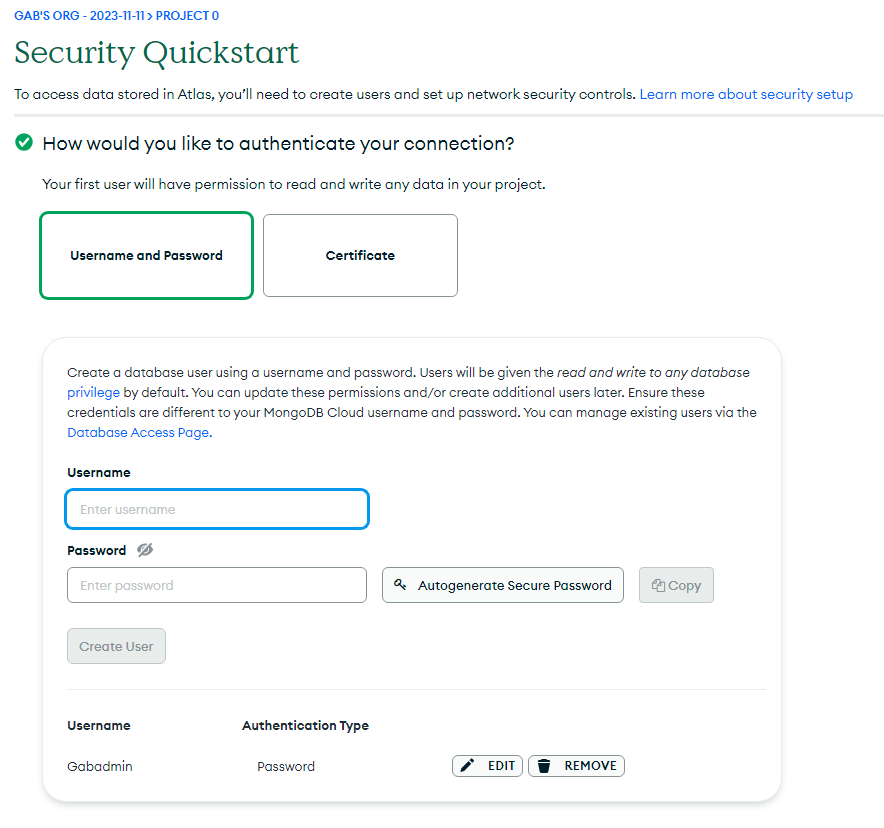

1. After this, you'll go to the database section and create the simulated database, to do this you'll need to browse the collections inside your cluster, clicking on the red are of the following image:<br><br> 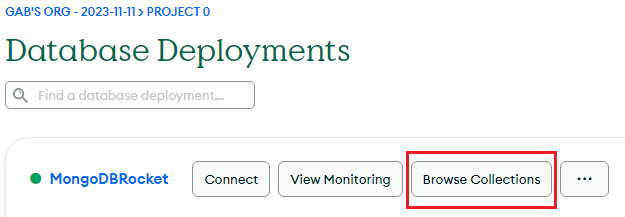 <br><br>
Then click "Create Database" and insert a name and a collection, the name should be "RocketfyProject" and the collection name should be "Orders" without any additional preferences <br><br> 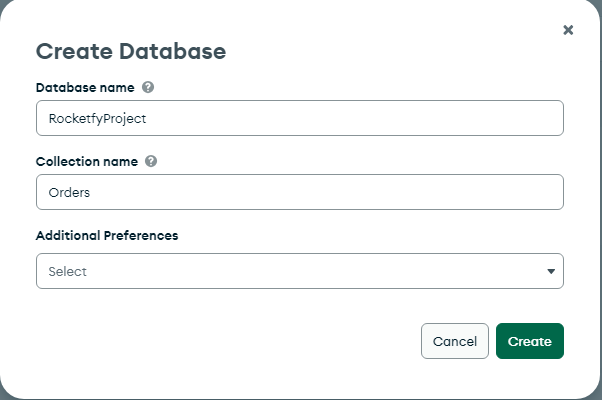

1. Then you'll go back to the database section and click "connect" <br> <br> 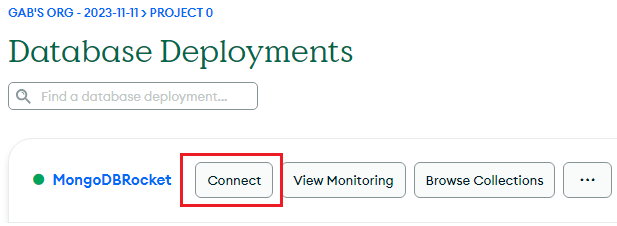 <br><br>
select "MongoDB for vscode" option <br><br> 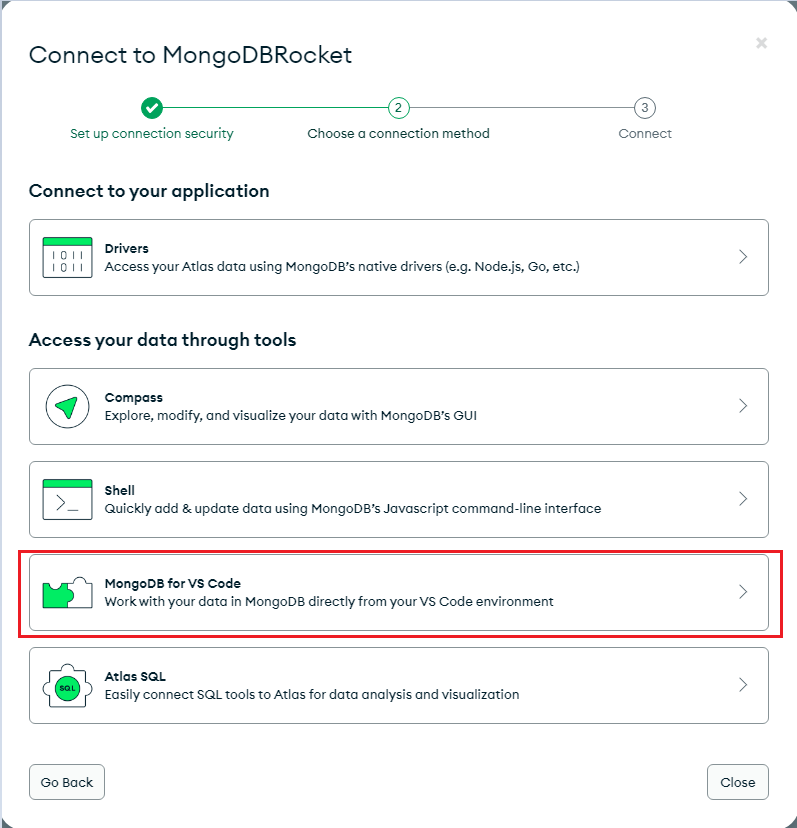 <br><br>
and copy the connection string or URI <br><br> 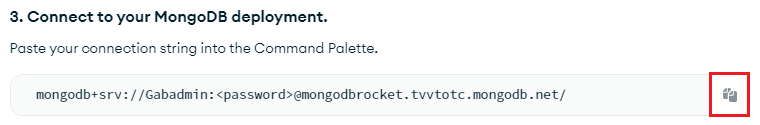 

1. Finally, you'll go to the .env file and paste the string in the "ATLAS_URI" field, make sure to replace <password> with the actual password of the database. You will also fill the "DB_NAME" field with the name of the database which will be "RocketfyProject" if you have followed the steps along. You can leave the other fields as they are for now.

### Connection to the Database

In [1]:
#Import the enviroment file info for the initial config and connect to the database

from pymongo import MongoClient
from dotenv import dotenv_values

config = dotenv_values(".env")

mongodb_client =  MongoClient(config["ATLAS_URI"], uuidRepresentation="standard")
database = mongodb_client[config["DB_NAME"]]
print("Connected to the MongoDB database!")

### Insertion to the Database

In the next code cell I define the functions needed to create and insert simulated data into the database, We already have a collection called "Orders" created so I will just insert all the data from the .csv file provided as documents inside the collection. 

After that, I'll create a new "Clients" collection to simulate fields as names and emails, the clients will be generated taking into account that there are multiple orders being done by the same client so we don't create duplicated documents. I will also only create clients for the values in "order_vendor_dbname" that present a valid pattern or structure such as "Text_Number" or "alphanumerical". This way I am already handling the errors that the corrupted or not valid data could present, one example of this kind of data is "fulanitoperensejoluisantoniodelbarrioconarepi" present in the .csv file

In [4]:
import random
from bson import ObjectId
import pandas as pd
from pymongo.database import Database


#Read the data of the simulated database provided by Rocketfy
data = pd.read_csv('db_envios_challenge.csv')

#These arrays will be used afterwards to generate fake names for the Clients of the simulated database that don't contain a name already
maleFirstNames = ["Henry","Simeon","Payton","Cortez","Dwayne","Messiah","Austin","Raiden","Marvin","Emerson","Michael","Kamron","Frank","Ivan","Camden","Corbin","Roman","Skylar","Jase","Aron"]
femaleFirstNames = ["Livia","Brooklynn","Baylee","Khloe","Autumn","Thalia","Azul","Mylee","Nia","Emely","Justine","Itzel","Kyla","Aliza","Jaylyn","Laylah","Marisa","Donna","Sandra","Michaela"]
lastNames = ["Terrell","Melendez","Petersen","Ibarra","Silva","Reeves","Robinson","Choi","Larson","Kim","Hines","Shelton","Kennedy","Nguyen","Walker","Hampton","Lynch","Goodwin","Cole","Stevenson","Castro","Osborne","Underwood","Leach","Flynn","Sloan","Burch","Tran","Bowers","Chan"]

#These regular expressions will be used afterwards to help in the creation of the pipelines and filtering for the MongoDB queries

patternCompanyClients = r"(\w+)_(\d+)" #This pattern will be used to extract the strings with "text_Number" structure found inside "order_vendor_dbname" column, for example "bigcolors_1381618804" 
patternClients = r"^[a-zA-Z0-9]{24}$" #This pattern will be used to extract the strings with an alphanumerical structure found inside "order_vendor_dbname" column, for example "6465208fbc1391265257ed5d"
patternValidDates = r"^((?:19|20)\d\d)-((?:0[1-9]|1[0-2]))-(?:0[1-9]|[12][0-9]|3[01])$" #This pattern will be used to extract the dates with 'yyyy-mm-dd' structure found inside "shipping_date" column, for example "2023-06-01"

#This function generates simulated info of a "Client" for the registers that contain alphanumerical values inside the "order_vendor_dbname" column in the simulated data
def generateClientInfo(isMale : bool, identificationNumber : str):

    if(isMale):
        random_name = random.choice(maleFirstNames) 
    else:
        random_name = random.choice(femaleFirstNames)

    random_lastName = random.choice(lastNames)

    result = {"name" : " ".join([random_name, random_lastName]), 
              "email" : random_name+random_lastName+"_"+str(random.randint(1,100))+"@gmail.com", 
              "_id" : ObjectId(identificationNumber),
              "identificationNumber": identificationNumber} 
    
    return result

#This function generates the info of a "Company Client" for the registers that contain "text_Number" like values inside the "order_vendor_dbname" column in the simulated data
def generateCompanyClientInfo(companyClientName : str, identificationNumber : str):

    result = {"name" : companyClientName, 
              "email" : companyClientName+"_"+str(random.randint(1,100))+"@gmail.com", 
              "identificationNumber" : companyClientName +"_"+ identificationNumber} 
    
    return result

#This function Initializes all the simulated data that the database will contain.
def initData(database : Database):

    #Insert Order documents to the Orders collection
    database["Orders"].insert_many(data.to_dict('records'))

    # Build the aggregation pipelines
    pipelineCompanyClients = [
        {
            #Filter documents that follow the "companyClientName + _ + number" expression
            '$match': {
            'order_vendor_dbname': {'$regex': patternCompanyClients}
            }
        },
        {
            #Group the query by the column "order_vendor_dbname" previously filtered
            '$group': {
            '_id': '$order_vendor_dbname',
            'count': {'$sum': 1}
        }
        },
        { 
            #Save all data returned by regexFind in patternLike
            '$project': {
                '_id': 0,
                'patternLike': {
                    '$regexFind': {
                        'input': '$_id',
                        'regex': patternCompanyClients
                    }
                }
            }
        },
        { 
            #Decompose captured data into their respective fields 
            '$project': {
                '_id': 0,
                'companyClientName':  {'$arrayElemAt' : ['$patternLike.captures', 0]},
                'companyIdentificationNumber': {'$arrayElemAt' : ['$patternLike.captures', 1]}
            }
        },
        
    ]

    pipelineClients = [
        {
            #Filter documents that have no special characters and are 24 characters long, in other words, ObjectsIds
            '$match': {
            'order_vendor_dbname': {'$regex': patternClients}
            }
        },
        {
            #Group the query by the column "order_vendor_dbname" previously filtered
            '$group':{
                '_id': '$order_vendor_dbname',
                'count': {'$sum': 1}
            }
        },
        {
            #Save the objectId element
            '$project':{
                '_id':0,
                'identificationNumber': '$_id'
            }
        }
    ]
    
    #Define client list to be inserted into the database
    clientsList = []
    clientsCounter = 0

    #Generate Company clients Info 
    for document in database["Orders"].aggregate(pipelineCompanyClients):
        client = generateCompanyClientInfo(document["companyClientName"], document["companyIdentificationNumber"])
        clientsCounter += 1
        clientsList.append(client)

    #Generate Clients Info
    for document in database["Orders"].aggregate(pipelineClients):
        client = generateClientInfo(random.choice([True, False]), document["identificationNumber"])
        clientsCounter += 1
        clientsList.append(client)        


    #Create and insert all Clients documents into the collection
    database['Clients'].insert_many(clientsList)
      
    return f"Sucessfully inserted {clientsCounter} clients"

The next code cell will initialize the data of the database with the .csv file provided and the fake clients created using the functions defined before. **ONLY RUN THIS CODE CELL IF IT'S THE FIRST TIME RUNNING THE PROJECT.**

In [ ]:
#initData(database)

### Setting the Email Service

In order to send the emails, We'll use Ethereal's fake SMTP service, go into [Ethereal main page](https://ethereal.email) and select "Create Ethereal Account" <br><br> 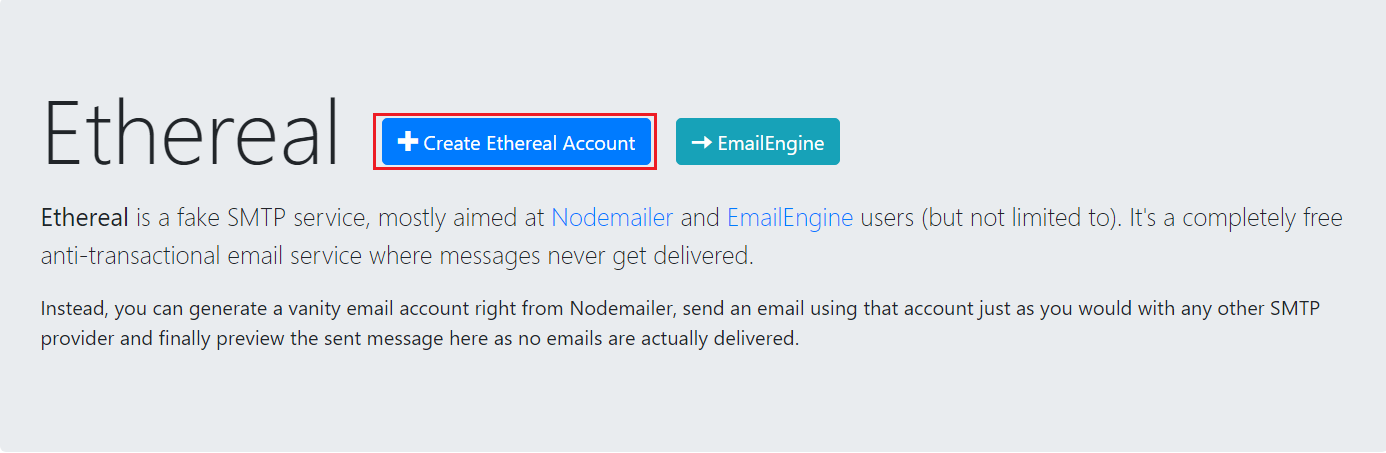

After this, scroll down the page to find all the SMTP configuration, copy these values and paste them into the ".env" file in their corresponding fields. You won't need to replace "SENDER_EMAIL" field. <br><br> 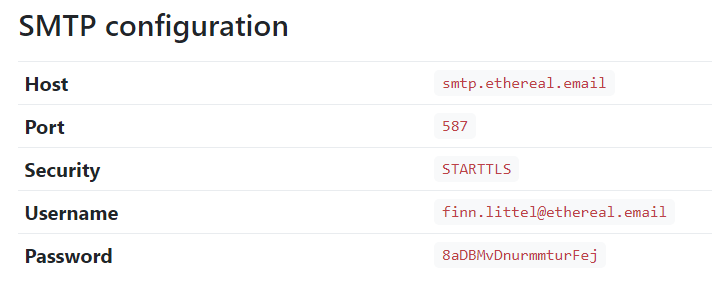

### Sending the Alarms 

In the next cell code I define the function used to send the alarms for those clients that have 3 or more orders in "cancelled" or "returned" status in the same month. Since there are a lot of clients that met this requirement, and by extend I should send more than 1000 emails, I limited the code to only send the first 5 emails on each call. 

This process is done using the "emailservice.py" script too

In [5]:
from emailservice import sendEmail

def sendAlarm(database: Database):
 
    alarmsCounter = 0

    pipelineAlarms = [
        {   
            #Filter documents that have a valid shipping date and order_vendor_dbname field which shipping status is cancelled or returned.
            '$match': {
                'shipping_date' : {'$regex': patternValidDates},
                'shipping_status': {"$in": ["cancelled", "returned"]},
                '$or': [{'order_vendor_dbname': {'$regex': patternCompanyClients}}, {"order_vendor_dbname": {"$regex": patternClients}}]
            }
        },
        {
            #Save all date info obtained from the regexFind into regexResult 
            '$addFields':{
                'regexResult': {'$regexFind': {
                        'input': '$shipping_date',
                        'regex': patternValidDates
                    }
                }
            }
        },
        {
            #Save all data into their respective fields 
            '$project':{
                '_id': 0,
                'shipping_id': '$shipping_id',
                'shipping_year': {'$arrayElemAt' : ['$regexResult.captures', 0] },
                'shipping_month': {'$arrayElemAt' : ['$regexResult.captures', 1] },
                'order_vendor_dbname': '$order_vendor_dbname'
            }
        },
        {
            #Group the query by the Client and month 
            '$group':{
                '_id': {
                    'order_vendor_dbname': '$order_vendor_dbname',
                    'shipping_year': '$shipping_year',
                    'shipping_month': '$shipping_month'
                },
                'shipping_ids': { '$push': '$shipping_id'},
                'count': {'$sum': 1}
            }
        },
        {   
            #Filter to get only the Clients that cancelled or returned three or more orders
             '$match': {
                "count": { "$gte": 3 }
            }
        },
        {
            #Limit the amount of results of the query
            '$limit': 5
        },
        {
            #Join with the Clients collection
            '$lookup': {
                "from": 'Clients',
                "localField": "_id.order_vendor_dbname",
                "foreignField": "identificationNumber",
                "as": "client"
            }
        },
        {
            #Save all the pertinent data that will be used in the email
            '$project':{
                '_id': 0,
                'clientName' : {'$arrayElemAt' : ['$client.name', 0]},
                'shipping_year': '$_id.shipping_year',
                'shipping_month': '$_id.shipping_month',
                'shipping_Id': '$shipping_ids',
                'clientEmail' : {'$arrayElemAt': ['$client.email', 0]}
            }
        } 
    ]

    #Send emails 
    for document in database["Orders"].aggregate(pipelineAlarms):
        result = sendEmail(document['clientEmail'], document['clientName'], document['shipping_year'], document['shipping_month'], document['shipping_Id'])
        print(result)
        alarmsCounter += 1
    print(alarmsCounter)
    
    return f"{alarmsCounter} emails have been sent"

### Automating the Task

For the automation of the task I will use APScheduler which is a lightweight and powerful library for scheduling tasks in Python. In order to proper observe the results the current job runs every minute, but for the solution of the problem I would suggest running it each month so it would create a monthly email for those Clients that cancelled or returned 3 or more orders in the same month

In [6]:
from apscheduler.schedulers.blocking import BlockingScheduler
import datetime

#My job is to send the alarms
def my_job():
    
    sendAlarm(database)
    print("Job executed at:", datetime.datetime.now())

# Create a scheduler instance
scheduler = BlockingScheduler()

# Add a job that runs every minute to be able to see the results of the exercise.
scheduler.add_job(my_job, 'interval', minutes=1)

try:
    print("Press Ctrl+C to exit.")
    scheduler.start()
except (KeyboardInterrupt, SystemExit):
    # Shut down the scheduler on Ctrl+C or system exit
    scheduler.shutdown()


Press Ctrl+C to exit.
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 15:55:34.885716
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 15:56:33.780661
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 15:57:32.671582
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 15:58:32.363745
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 15:59:33.343586
Message sent
Message sent
Message sent
Message sent
Message sent
5
Job executed at: 2023-11-13 16:00:32.857160
